# Tarea 2 (10 puntos). Operaciones con RDDs
- Obtener información de algún origen de datos (propio o de API)
- Convertir el origen de datos a RDD con pySpark
- Realizar alguna operación en el RDD, como estadísticas descriptivas básicas
- Subir la práctica a un repositorio público y etiquetarla claramente

In [42]:
import os
import sys
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum
from pyspark import SparkConf, SparkContext

In [43]:
spark = SparkSession.builder.appName("Tarea 2").master("local[*]").getOrCreate()
sc = spark.sparkContext

In [44]:
df = spark.read.csv("mortgage_data.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- SOURCE: string (nullable = true)
 |-- FREQUENCY: string (nullable = true)
 |-- SERIESID: string (nullable = true)
 |-- GEOLEVEL: string (nullable = true)
 |-- GEOID: string (nullable = true)
 |-- GEONAME: string (nullable = true)
 |-- MARKET: string (nullable = true)
 |-- PERIOD: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- SUPPRESSED: integer (nullable = true)
 |-- VALUE1: double (nullable = true)
 |-- VALUE2: double (nullable = true)



In [45]:
df.show(5)

+------+---------+--------+--------+-----+-------------+--------------------+------+----+-------+-----+----------+------+--------+
|SOURCE|FREQUENCY|SERIESID|GEOLEVEL|GEOID|      GEONAME|              MARKET|PERIOD|YEAR|QUARTER|MONTH|SUPPRESSED|VALUE1|  VALUE2|
+------+---------+--------+--------+-----+-------------+--------------------+------+----+-------+-----+----------+------+--------+
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|       All Mortgages|1998Q1|1998|      1|    3|         0|2544.0|277368.0|
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|All Mortgages (Ho...|1998Q1|1998|      1|    3|         0|1044.0|108582.0|
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|All Mortgages (Re...|1998Q1|1998|      1|    3|         0|1499.0|168786.0|
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|       All Mortgages|1998Q2|1998|      2|    6|         0|2910.0|319970.0|
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|All Mortgages (Ho...|1998Q2

In [46]:
rdd_original = df.rdd

In [47]:
# Filtrar valores donde VALUE1 y VALUE2 sean mayores que 0
rdd_data =  rdd_original.filter(lambda row: row['VALUE1'] and row['VALUE2'] and row['VALUE1'] > 0 and row['VALUE2'] > 0)

# Verificar cuántos registros quedan después de la limpieza
print(f"Registros originales: {rdd_original.count()}")
print(f"Registros después de limpiar valores 0: {rdd_data.count()}")

Registros originales: 2007264
Registros después de limpiar valores 0: 1677096


In [48]:
# Extraer las columnas VALUE1 y VALUE2 para estadísticas
value1 = rdd_data.map(lambda row: row["VALUE1"]).filter(lambda x: x is not None).collect()
value2 = rdd_data.map(lambda row: row["VALUE2"]).filter(lambda x: x is not None).collect()
# Calcular estadísticas descriptivas
def calcular_estadisticas(valores, columna):
    print(f"\nEstadísticas para {columna}:")
    print(f"  Mínimo: {min(valores)}")
    print(f"  Máximo: {max(valores)}")
    print(f"  Media: {statistics.mean(valores)}")
    print(f"  Mediana: {statistics.median(valores)}")
    print(f"  Varianza: {statistics.variance(valores)}")
    print(f"  Desviación Estándar: {statistics.stdev(valores)}")
    print(f"  Suma: {sum(valores)}")
    print(f"  Conteo: {len(valores)}")

# Calcular estadísticas para VALUE1 y VALUE2
calcular_estadisticas(value1, "VALUE1")
calcular_estadisticas(value2, "VALUE2")


Estadísticas para VALUE1:
  Mínimo: 0.1
  Máximo: 6161.0
  Media: 47.73339564342172
  Mediana: 23.4
  Varianza: 13469.394732234501
  Desviación Estándar: 116.05772155369284
  Suma: 80053486.89997195
  Conteo: 1677096

Estadísticas para VALUE2:
  Mínimo: 0.1
  Máximo: 1159331.0
  Media: 852.8413477224917
  Mediana: 24.0
  Varianza: 137095845.24771655
  Desviación Estándar: 11708.793500942638
  Suma: 1430296812.898748
  Conteo: 1677096


In [49]:
# Filtrar las filas donde el año (YEAR) sea mayor a 2010
rdd_filtered = rdd_data.filter(lambda row: row['YEAR'] > 2010)

# Calcular el costo promedio por hipoteca (VALUE2 / VALUE1)
rdd_costo_hipoteca = rdd_filtered.map(lambda row: (row['YEAR'], row['VALUE2'], row['VALUE2'] / row['VALUE1']))
rdd_costo_hipoteca.take(5)

[(2011, 315703.0, 208.24736147757255),
 (2011, 92100.0, 196.37526652452024),
 (2011, 223603.0, 213.56542502387774),
 (2011, 283723.0, 198.96423562412343),
 (2011, 129088.0, 194.1172932330827)]

In [50]:
# Filtrar columnas relevantes (YEAR y VALUE2)
rdd_graphics_value1 = rdd_filtered.map(lambda x: (int(x['YEAR']), float(x['VALUE1'])))
rdd_graphics_value2 = rdd_filtered.map(lambda x: (int(x['YEAR']), float(x['VALUE2'])))

In [51]:

# Calcular la suma total de VALUE1 por YEAR
rdd_suma_anual_value1 = rdd_graphics_value1.reduceByKey(lambda x, y: x + y)
# Calcular la suma total de VALUE2 por YEAR
rdd_suma_anual_value2 = rdd_graphics_value2.reduceByKey(lambda x, y: x + y)
# Recolectar y ordenar los datos
suma_value1_por_anio = rdd_suma_anual_value1.collect()
suma_value2_por_anio = rdd_suma_anual_value2.collect()

In [52]:
suma_value1_por_anio.sort(key=lambda x: x[0])  # Ordenar por YEAR
suma_value2_por_anio.sort(key=lambda x: x[0])  # Ordenar por YEAR

In [53]:
rdd_suma_anual_value1.take(5)

[(2012, 3212535.5000000373),
 (2014, 3086368.2000000197),
 (2016, 3140045.599999999),
 (2018, 3098102.1000000015),
 (2020, 3301797.1000000257)]

In [54]:
# Separar años y valores de suma para VALUE1
años_value1 = [x[0] for x in suma_value1_por_anio]
valores_value1 = [x[1] for x in suma_value1_por_anio]

# Separar años y valores de suma para VALUE2
años_value2 = [x[0] for x in suma_value2_por_anio]
valores_value2 = [x[1] for x in suma_value2_por_anio]

In [55]:
# Imprimir los resultados
print("Cantidad de hipotecas por Año:")
for año, suma in suma_value1_por_anio:
    print(f"Año: {año}, Suma: {suma}")

print("\nCantidad de dolares en hipotecas por Año:")
for año, suma in suma_value2_por_anio:
    print(f"Año: {año}, Suma: {suma}")

Cantidad de hipotecas por Año:
Año: 2011, Suma: 3131059.7000000095
Año: 2012, Suma: 3212535.5000000373
Año: 2013, Suma: 3172331.80000001
Año: 2014, Suma: 3086368.2000000197
Año: 2015, Suma: 3118013.3000000003
Año: 2016, Suma: 3140045.599999999
Año: 2017, Suma: 3112451.800000016
Año: 2018, Suma: 3098102.1000000015
Año: 2019, Suma: 3146169.999999969
Año: 2020, Suma: 3301797.1000000257
Año: 2021, Suma: 3307929.200000003
Año: 2022, Suma: 3118744.800000006
Año: 2023, Suma: 2294938.700000004

Cantidad de dolares en hipotecas por Año:
Año: 2011, Suma: 40360693.800001025
Año: 2012, Suma: 57555581.90000054
Año: 2013, Suma: 49232995.90000102
Año: 2014, Suma: 34288899.00000056
Año: 2015, Suma: 43821570.89999957
Año: 2016, Suma: 51375358.30000056
Año: 2017, Suma: 44673444.6000017
Año: 2018, Suma: 41632162.20000033
Año: 2019, Suma: 57748537.50000068
Año: 2020, Suma: 102903859.4999993
Año: 2021, Suma: 110942362.99999891
Año: 2022, Suma: 57986701.40000033
Año: 2023, Suma: 28330531.800000522


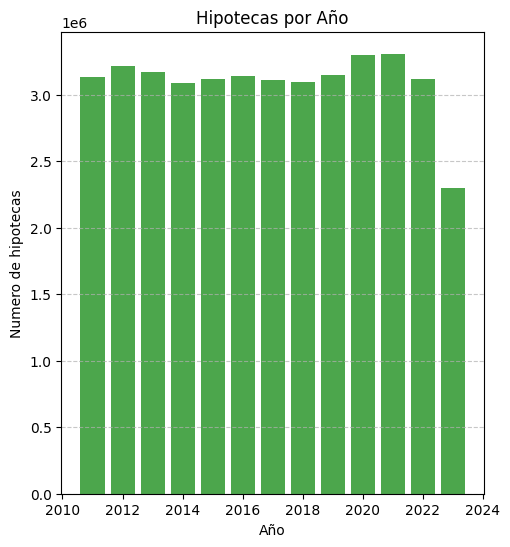

In [56]:
# Crear figuras
plt.figure(figsize=(12, 6))
# Gráfico 1: Suma de VALUE1
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, gráfico 1
plt.bar(años_value1, valores_value1, color='g', alpha=0.7)
plt.xlabel('Año')
plt.ylabel('Numero de hipotecas')
plt.title('Hipotecas por Año')
plt.grid(axis='y', linestyle='--', alpha=0.7)

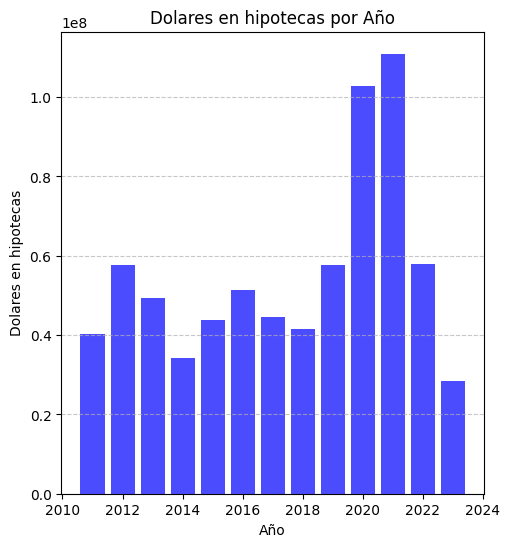

In [57]:
# Gráfico 2: Suma de VALUE2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, gráfico 2
plt.bar(años_value2, valores_value2, color='b', alpha=0.7)
plt.xlabel('Año')
plt.ylabel('Dolares en hipotecas')
plt.title('Dolares en hipotecas por Año')
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [58]:
# Filtrar columnas relevantes (MARKET y VALUE2)
rdd_market_value2 = rdd_data.map(lambda x: (x['MARKET'], float(x['VALUE2'])))

# Agrupar por MARKET y calcular la suma total de VALUE2
rdd_suma_market_value2 = rdd_market_value2.reduceByKey(lambda x, y: x + y)

# Recolectar los datos y ordenar por la suma (descendente)
suma_market_value2 = rdd_suma_market_value2.collect()
suma_market_value2.sort(key=lambda x: x[1], reverse=True)  # Ordenar por suma de VALUE2 (descendente)

# Obtener los primeros 20 resultados
primeros_20 = suma_market_value2[:20]

# Imprimir los primeros 20 resultados
print("Primeros 20 Mercados por Suma de VALUE2:")
for i, (mercado, suma) in enumerate(primeros_20, start=1):
    print(f"{i}. Mercado: {mercado}, Suma de VALUE2: {suma}")


Primeros 20 Mercados por Suma de VALUE2:
1. Mercado: All Mortgages, Suma de VALUE2: 158600046.3999966
2. Mercado: Conventional Market, Suma de VALUE2: 134345063.59999827
3. Mercado: Conforming Market, Suma de VALUE2: 133183758.29999822
4. Mercado: Conventional Conforming Market, Suma de VALUE2: 108928311.99999876
5. Mercado: All Mortgages (Refinance), Suma de VALUE2: 91957263.89999826
6. Mercado: Enterprise Acquisitions, Suma de VALUE2: 82664098.49999899
7. Mercado: Conventional Market (Refinance), Suma de VALUE2: 82018514.6999998
8. Mercado: Conforming Market (Refinance), Suma de VALUE2: 77887633.1999983
9. Mercado: All Mortgages (Home Purchase), Suma de VALUE2: 69712965.99999784
10. Mercado: Conventional Conforming Market (Refinance), Suma de VALUE2: 67948319.20000042
11. Mercado: Conforming Market (Home Purchase), Suma de VALUE2: 58360232.10000107
12. Mercado: Conventional Market (Home Purchase), Suma de VALUE2: 55400518.000000305
13. Mercado: Enterprise Acquisitions (Refinance), Su

In [59]:
# Renombrar columnas
df = df.withColumnRenamed("VALUE1", "MORT_NUMBER").withColumnRenamed("VALUE2", "DOLLAR_MEAN")

# Crear nueva columna promediada
df = df.withColumn("VOL_DOLLAR", (col("MORT_NUMBER") * 20 * col("DOLLAR_MEAN")))

# Mostrar resultado
df.show()

+------+---------+--------+--------+-----+-------------+--------------------+------+----+-------+-----+----------+-----------+-----------+--------------+
|SOURCE|FREQUENCY|SERIESID|GEOLEVEL|GEOID|      GEONAME|              MARKET|PERIOD|YEAR|QUARTER|MONTH|SUPPRESSED|MORT_NUMBER|DOLLAR_MEAN|    VOL_DOLLAR|
+------+---------+--------+--------+-----+-------------+--------------------+------+----+-------+-----+----------+-----------+-----------+--------------+
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|       All Mortgages|1998Q1|1998|      1|    3|         0|     2544.0|   277368.0|1.411248384E10|
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|All Mortgages (Ho...|1998Q1|1998|      1|    3|         0|     1044.0|   108582.0|  2.26719216E9|
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|All Mortgages (Re...|1998Q1|1998|      1|    3|         0|     1499.0|   168786.0|  5.06020428E9|
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|       All Mortgages

In [64]:
# Para guardarlo en Google Drive (opcional)
from google.colab import drive
drive.mount('/content/drive')

# Ruta en tu Google Drive
output_path = '/content/drive/My Drive/processed_data.csv'
df=df.coalesce(1)
df.write.csv(output_path, header=True, mode='overwrite')


print(f"Archivo guardado como: {output_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo guardado como: /content/drive/My Drive/processed_data.csv


In [ ]:
spark.stop()
